This notebook is designed to forecast electricity usage using time series forecasting and machine learning techniques

1. Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from prophet import Prophet

2. Load data

In [ ]:
with open("household_power_consumption.txt") as f:
    print(f.readline())

# Load dataset with proper separator and parse dates
df = pd.read_csv(
    "household_power_consumption.txt",
    sep=';',
    parse_dates={'Datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values=['?'],
    low_memory=False
)

print(df.head())

Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3



C:\Users\arifu\AppData\Local\Temp\ipykernel_10996\1811372930.py:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\arifu\AppData\Local\Temp\ipykernel_10996\1811372930.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\arifu\AppData\Local\Temp\ipykernel_10996\1811372930.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


             Datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


3. Clean data and resample to hourly frequency so it's easier to process

In [ ]:
# Convert all columns except 'Datetime' to numeric, coercing errors to NaN
for col in df.columns:
    if col != 'Datetime':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Set 'Datetime' as index for time series operations
df.set_index('Datetime', inplace=True)


# === Resample Data to Hourly Frequency ===

# Resample to hourly mean values for smoother data
df_hourly = df.resample('H').mean()

C:\Users\arifu\AppData\Local\Temp\ipykernel_10996\1764031096.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


4. Prepare dataset for forecasting and target variables

In [ ]:
# Shift target variable (next hour's Global_active_power)
df_hourly['Target'] = df_hourly['Global_active_power'].shift(-1)
df_hourly.dropna(inplace=True)  # Drop last row with NaN target

# Define features and target variable
X = df_hourly.drop(columns=['Target'])
y = df_hourly['Target']


# === Train-Test Split ===

# Use sequential split (no shuffle) due to time series nature
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

5. Train Random Forest model

In [14]:
# === Train Random Forest Regressor ===

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


6. Make predictions and demonstrate values using that model

MAE: 0.39233388889428467
RMSE: 0.5428118380513328


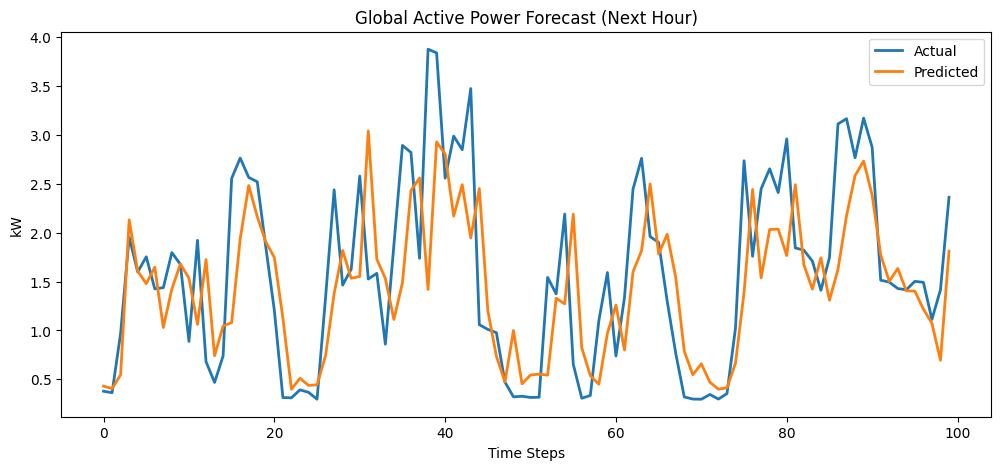

In [ ]:


y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



# plot actual vs predicted values
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', linewidth=2)
plt.plot(y_pred[:100], label='Predicted', linewidth=2)
plt.title('Global Active Power Forecast (Next Hour)')
plt.xlabel('Time Steps')
plt.ylabel('kW')
plt.legend()
plt.show()


We can see from the graph that the predicted forecast very closely matches the actual forecast for the hour. This makes the model accurate and that is further influenced by the MAE and RMSE. With a larger time range this could allow the model to be tested more rigorously.

From the trend it is clear that prophet would be better suited to the data because this shows season trends and prophet is designed to work in this type of time series forcasting

7. Make a feature importance to show which details were most important to the model.

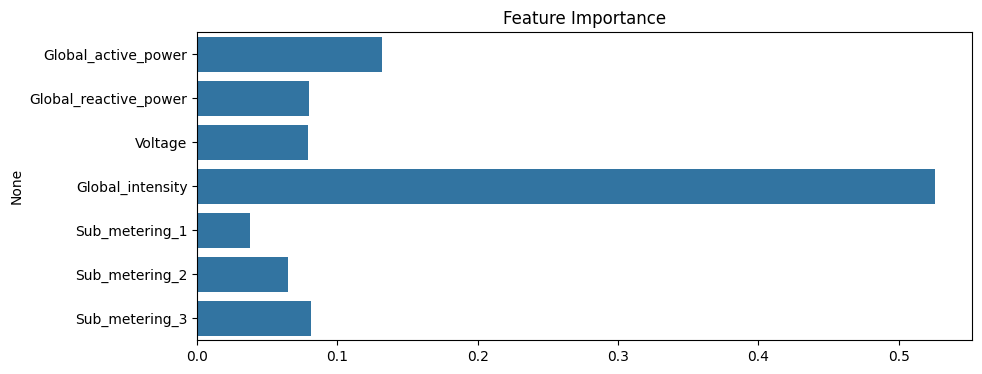

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importance")
plt.show()

From here Global_intensity emerged as the most influential predictor for forecasting the next hour's Global Active Power. Thi intuitive sense because it relates to the overall electrical current flowing through the household, which is closely linked to power consumption.

Global_active_power also contributed significantly, showing that recent power consumption levels are valuable indicators for short-term forecasting.


8. Create the prophet model and show the forecast

20:09:16 - cmdstanpy - INFO - Chain [1] start processing
20:09:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\arifu\Documents\Homework\2ndYear\miniconda3\envs\ml-env\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


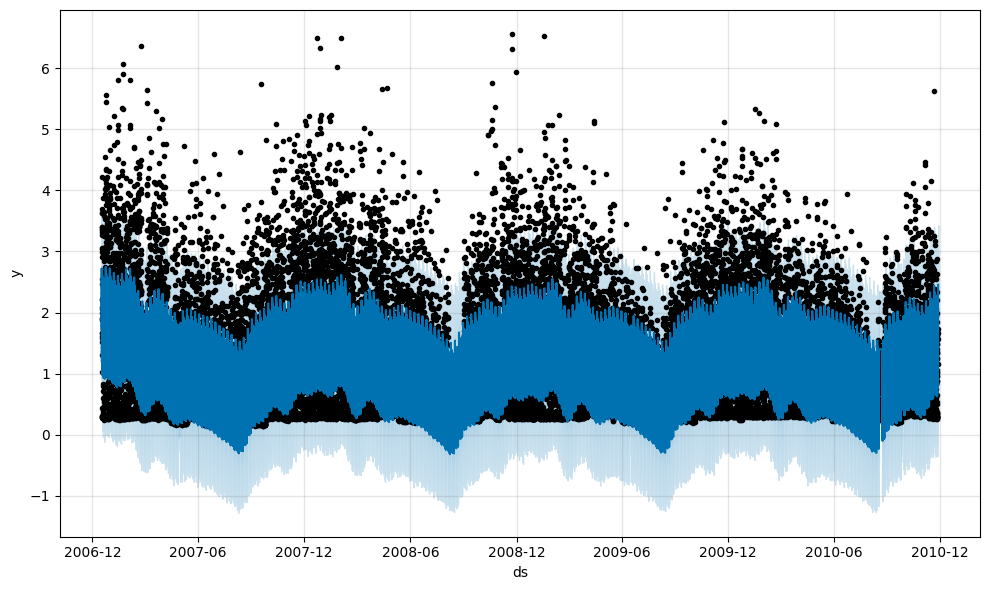

In [17]:
# === Prophet Model for Comparison ===

# Prepare data for Prophet: rename columns as Prophet requires 'ds' and 'y'
df_prophet = df_hourly.reset_index()[['Datetime', 'Global_active_power']].rename(
    columns={'Datetime': 'ds', 'Global_active_power': 'y'}
)

# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Create future dataframe for next 24 hours
future = prophet_model.make_future_dataframe(periods=24, freq='H')

# Predict future values
forecast = prophet_model.predict(future)

# Plot forecast
fig = prophet_model.plot(forecast)

From here it can be seen that prophet is strongly picking up the seasonality. The band is also narrow suggesting the model is accurate and is able to focus more clearly on the trend rather than show skew.